# Kmeans

Es un algoritmo que depende del cálculo de distancias, por lo tanto es necesario escalar las variables

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
USArrests = sm.datasets.get_rdataset("USArrests", "datasets")
datos = USArrests.data
datos=datos.reset_index()
datos.head(4)

,rownames,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5


In [3]:
from sklearn.preprocessing import StandardScaler

#df=datos.apply(scale)
scaler = StandardScaler()
scaler.fit(datos.drop(columns="rownames"))
df=pd.DataFrame(scaler.transform(datos.drop(columns="rownames")), columns=["Murder","Assault","UrbanPop","Rape"])
df=pd.concat([datos["rownames"],df], axis=1, verify_integrity=True)
df.head()

,rownames,Murder,Assault,UrbanPop,Rape
0,Alabama,1.255179,0.790787,-0.526195,-0.003451
1,Alaska,0.513019,1.118060,-1.224067,2.509424
2,Arizona,0.072361,1.493817,1.009122,1.053466
3,Arkansas,0.234708,0.233212,-1.084492,-0.186794
4,California,0.281093,1.275635,1.776781,2.088814


Lo más dificil es calcular el número óptimo de clusters, para esto, es importante realiza tres pruebas: Método elbow, avarage silhouette y estadística gap. No siempre coinciden los valores pero sirve para acotar las opciones.

## Ejemplo creado aleatoreamente

Fuente: Usando la página https://cienciadedatos.net/documentos/py20-clustering-con-python

In [1]:
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Generate isotropic Gaussian blobs for clustering.

X, y = make_blobs(
        n_samples    = 300, 
        n_features   = 2, 
        centers      = 4, 
        cluster_std  = 0.60, 
        shuffle      = True, 
        random_state = 0
       )

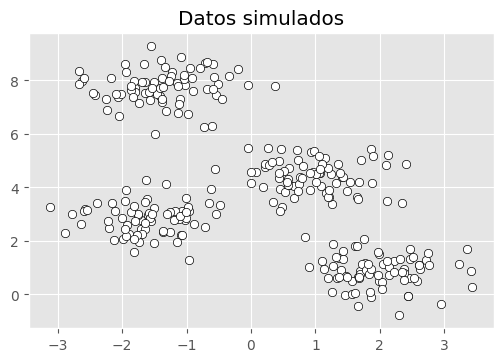

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1], 
    c = 'white',
    marker    = 'o',
    edgecolor = 'black', 
)
ax.set_title('Datos simulados');

In [5]:
from sklearn.cluster import KMeans

X_scaled = scale(X)
kmeans = KMeans(n_clusters=4, n_init=25, random_state=123)
kmeans.fit(X_scaled)

NameError: name 'scale' is not defined

In [11]:
y_pred = kmeans.predict(X_scaled)

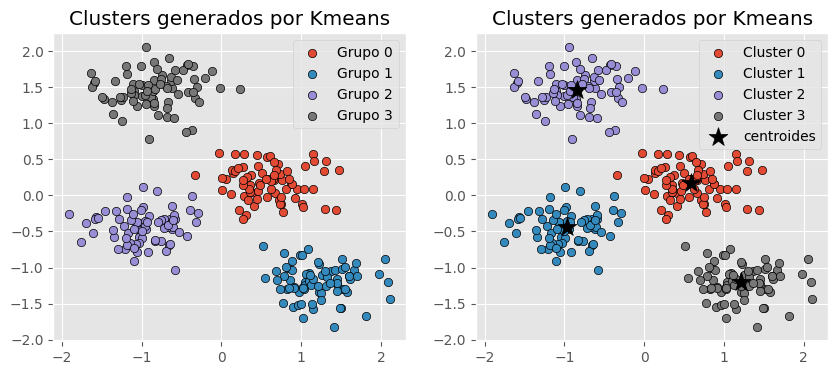

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
    
ax[0].set_title('Clusters generados por Kmeans')
ax[0].legend();

for i in np.unique(y_pred):
    ax[1].scatter(
        x = X_scaled[y_pred == i, 0],
        y = X_scaled[y_pred == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Cluster {i}"
    )
    
ax[1].scatter(
    x = kmeans.cluster_centers_[:, 0],
    y = kmeans.cluster_centers_[:, 1], 
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();

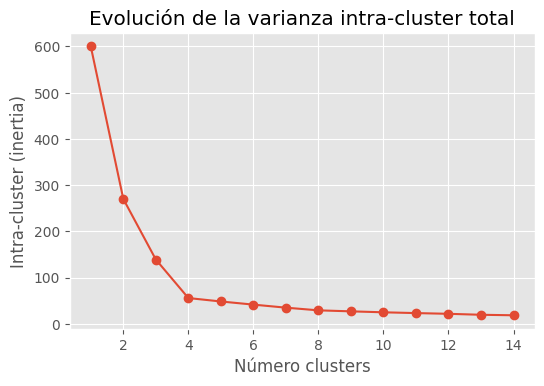

In [16]:


# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    modelo_kmeans.fit(X_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');



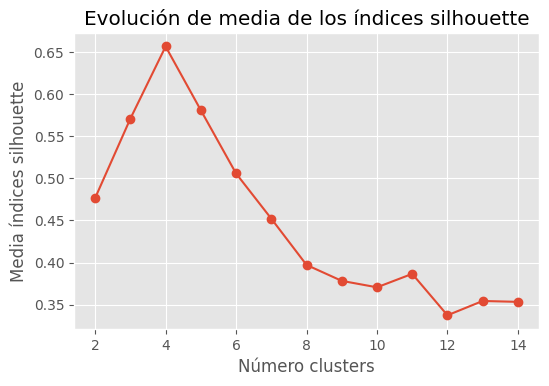

In [17]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Otro método es el estadístico gap que se calcula con esta función extraida de https://www.analyticslane.com/2023/06/02/optimizar-el-numero-de-clusteres-con-gap-statistics/

In [18]:

from scipy.spatial.distance import cdist


def gap_statistics(data, k_max, num_sim=10):
    """
    Estima el número óptimo de clusters en un conjunto de datos utilizando el método de Gap Statistics.

    Parámetros:
    -----------
    data : array, shape (n_samples, n_features)
        El conjunto de datos de entrada.
    k_max : int
        El número máximo de clusters a considerar.
    num_sim : int, default=10
        El número de simulaciones aleatorias a utilizar para la distribución de referencia.

    Retorna:
    --------
    k_opt : int
        El número óptimo de clusters para el cojunto de datos
    gap : array, shape (k_max,)
        La estadística de Gap para cada número de clusters k.
    s_k : array, shape (k_max,)
        La desviación estándar de la estadística de Gap para cada número de clusters k.
    """

    # Calcula los rangos de los datos
    ranges = np.apply_along_axis(lambda x: x.max() - x.min(), axis=0, arr=data)

    # Inicializa las matrices para la función de error W_k
    w_k = np.zeros(k_max)
    w_k_star = np.zeros((k_max, num_sim))

    # Calcula la función de error W_k y W_k_star para cada valor de k
    for k in range(1, k_max + 1):
        # Ejecuta el algoritmo de K-means para k clusters
        kmeans = KMeans(n_clusters=k).fit(data)
        # Calcula la función de error W_k para los datos de entrada
        w_k[k - 1] = np.sum(np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0]
        # Genera num_sim muestras aleatorias de los datos y calcula la función de error W_k_star para cada muestra
        for sim in range(num_sim):
            random_data = np.random.random_sample(size=data.shape) * ranges + np.min(data, axis=0)
            kmeans = KMeans(n_clusters=k).fit(random_data)
            w_k_star[k - 1, sim] = np.sum(np.min(cdist(random_data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / random_data.shape[0]

    # Calcula la estadística de Gap para cada valor de k
    gap = np.log(w_k_star.mean(axis=1)) - np.log(w_k)

    # Calcula la desviación estándar de la estadística de Gap
    s_k = np.sqrt(1 + 1 / num_sim)*np.std(np.log(w_k_star), axis=1)

    # Encuentra el número óptimo de clusters k
    k_opt = np.argmax(gap) + 1

    # Regresa la estadística de Gap y su desviación estándar
    return k_opt, gap, s_k

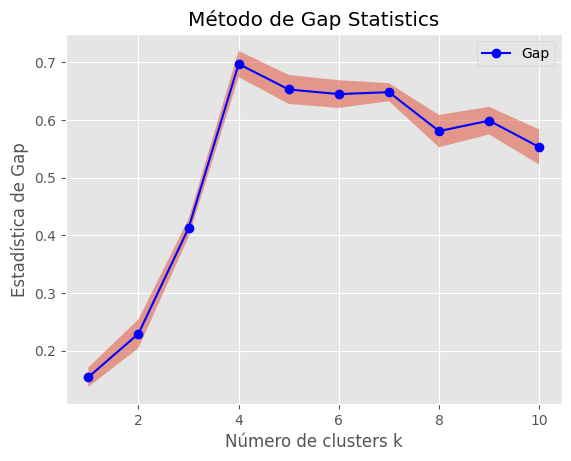

In [24]:
import matplotlib.pyplot as plt
k_max = 10
k, gap, s_k = gap_statistics(X_scaled, k_max=k_max, num_sim=10)
# Grafica la estadística de Gap y su desviación estándar
plt.plot(range(1, k_max + 1), gap, 'bo-', label='Gap')
plt.fill_between(range(1, k_max + 1), gap - s_k, gap + s_k, alpha=0.5)
plt.xlabel('Número de clusters k')
plt.ylabel('Estadística de Gap')
plt.title('Método de Gap Statistics')
plt.legend()
plt.show()

# Aplicando todo lo anterior con el set del inicio (crimenes por estado)

En este caso no hay valores nulos y los datos ya están limpios, sólo es aplicar los conceptos anteriores a "df". A diferencia del ejemplo creado, donde sabiamos que habían 4 clusters, en este caso no conocemos el número de clusters que puede haber, así que lo primero es usar los tres métodos descritos arriba.

In [98]:
kmeans=KMeans(n_clusters=4)
kmeans.fit(df.drop(columns="rownames"))


KMeans(n_clusters=4)

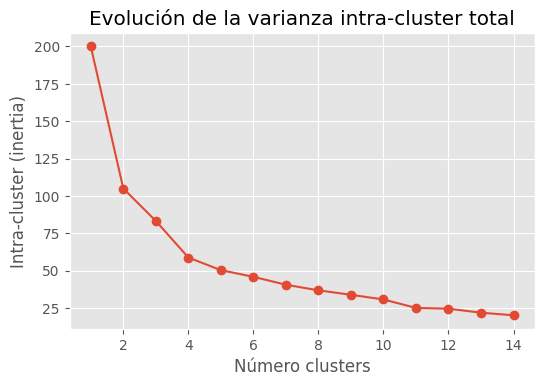

In [99]:
## Elbow

range_n_clusters = range(1,15)
inertias = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters) 
    kmeans.fit(df.drop(columns="rownames"))
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

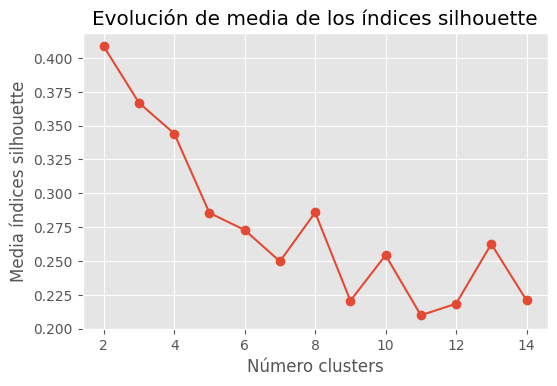

In [100]:
range_n_clusters = range(2, 15) ## Vea que arranca es desde el 2 y no el 1
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters = n_clusters)
    cluster_labels = kmeans.fit_predict(df.drop(columns="rownames"))
    silhouette_avg = silhouette_score(df.drop(columns="rownames"), cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [55]:
# k_max = 15
# k, gap, s_k = gap_statistics(df.reset_index().drop(columns="rownames"), k_max=k_max, num_sim=10)
# # Grafica la estadística de Gap y su desviación estándar
# plt.plot(range(1, k_max + 1), gap, 'bo-', label='Gap')
# plt.fill_between(range(1, k_max + 1), gap - s_k, gap + s_k, alpha=0.5)
# plt.xlabel('Número de clusters k')
# plt.ylabel('Estadística de Gap')
# plt.title('Método de Gap Statistics')
# plt.legend()
# plt.show()

No me funcionó la función anterior, pero con el método elbow y siluette vemos que 2 es un número bueno de clusters

In [6]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df.drop(columns="rownames"))

KMeans(n_clusters=2)

In [7]:
df["cluster"] = kmeans.labels_

In [8]:
datos["cluster"]=df["cluster"]

In [9]:
datos.sort_values(by="cluster")

,rownames,Murder,Assault,UrbanPop,Rape,cluster
3,Arkansas,8.8,190,50,19.5,0
7,Delaware,5.9,238,72,15.8,0
6,Connecticut,3.3,110,77,11.1,0
15,Kansas,6.0,115,66,18.0,0
13,Indiana,7.2,113,65,21.0,0
14,Iowa,2.2,56,57,11.3,0
10,Hawaii,5.3,46,83,20.2,0
11,Idaho,2.6,120,54,14.2,0
25,Montana,6.0,109,53,16.4,0
26,Nebraska,4.3,102,62,16.5,0


No es fácil evaluar el modelos debido a que no tenemos etiquetas para evaluar.]

Página muy útil para explicar todo lo relacionado de K-means, incluyendo la limpieza de datos, PCA, etc.

https://medium.com/@nirmalsankalana/k-means-clustering-choosing-optimal-k-process-and-evaluation-methods-2c69377a7ee4